<a href="https://colab.research.google.com/github/lorincastro/IT304S-UFJF/blob/main/IT304S_UFJF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo do Trabalho

O presente trabalho tem o objetivo de analisar os dados das faturas de energia dos últimos 5 anos da Universidade Federal de Juiz de Fora (UFJF), e através da estimativa de consumo futuro, com base em conceitos básicos de data science, será feito um estudo de viabilidade técnico-econômica para a possibilidade de migração da universidade para o mercado livre de energia, com a proposta de um modelo de contrato para tal.

# Preparação dos Dados

In [ ]:
! pip install pmdarima

## Clonagem do repositório no Github

In [ ]:
!git clone https://github.com/lorincastro/IT304S-UFJF.git

In [ ]:
import pandas as pd

## Reconhecimento da planilha eletrônica das faturas UFJF
Primeiro passo do código é reconhecer a planilha com os dados de fatura digitalizados, desenvolvida na primeira parte desse trabalho. Para o caso em estudo, nos foram disponibilizadas apenas as faturas do campus Juiz de Fora. A UFJF ainda tem um segundo campus, em Governador Valadares, o qual não tivemos acesso às faturas. O total de faturas ca Campus JF foi 60, dos meses de Jul/15 a Jun/20.

In [ ]:
abas_de_excel =  pd.ExcelFile("/content/IT304S-UFJF/UFJF.xlsx")
abas_de_excel.sheet_names

['Apresentação', 'UC - JF']

In [ ]:
UC1 = abas_de_excel.parse("UC - JF")
UC1.shape

(60, 31)

In [ ]:
UC1.head()

,DATA,ANO,MÊS,PERIODO,PIS/PASEP,COFINS,ICMS,DEMANDA_CONTRATADA_P,DEMANDA_CONTRATADA_FP,DEMANDA_REGISTRADA_P,DEMANDA_REGISTRADA_FP,DEMANDA_ISENTA_P,DEMANDA_ISENTA_FP,TAR_TUSD_KW_P,TAR_TUSD_KW_FP,ENERGIA_PONTA,ENERGIA_FPONTA,TAR_TUSD_KWH_P,TAR_TUSD_KWH_FP,TAR_TE_KWH_P,TAR_TE_KWH_FP,REAT_KVAR_PONTA,REAT_KVAR_FPONTA,TAR_REAT_PONTA,TAR_REAT_FPONTA,Valor da Fatura,Consumo Total,TAR_DEMANDA_ULTRAPASSADA,Acrescimo_Bamar,Acrescimo_Bverm1,Acrescimo_Bverm2
0,2015-07-01,2015,7,31,0.0117,0.0541,0.06,NaN,1400,1096,1060,NaN,304,NaN,9.0,56400,426800,NaN,NaN,1.229980,0.364760,20000,172400,NaN,0.23919,262880.03,483200,18.0,0.0,30400.35,NaN
1,2015-08-01,2015,8,31,0.0130,0.0601,0.06,NaN,1400,896,888,NaN,504,NaN,9.0,47600,410800,NaN,NaN,1.229657,0.364437,18000,168000,NaN,0.23919,246011.30,458400,18.0,0.0,28912.35,NaN
2,2015-09-01,2015,9,30,0.0130,0.0598,0.06,NaN,1400,900,1092,NaN,308,NaN,9.0,47600,412000,NaN,NaN,1.219980,0.354760,17600,166800,NaN,0.23919,240945.00,459600,18.0,0.0,23849.14,NaN
3,2015-10-01,2015,10,31,0.0112,0.0508,0.06,NaN,1400,1160,1336,NaN,64,NaN,9.0,52400,475600,NaN,NaN,1.219980,0.354760,18800,188000,NaN,0.23919,268446.13,528000,18.0,0.0,27061.49,NaN
4,2015-11-01,2015,11,30,0.0093,0.0428,0.06,NaN,1400,1344,1780,NaN,0,NaN,9.0,69200,572000,NaN,NaN,1.219980,0.354760,22800,214800,NaN,0.23919,368935.34,641200,18.0,0.0,32496.89,NaN


In [ ]:
import numpy as np
np.isnan(np.nan)

## Verificação dos dados faltantes
Nessa etapa foi possível visualizar que algumas variáveis da planilha original sequer tiveram dados preenchidos, visto que a modalidade tarifária dessa UC não possuía diferença de demanda ponta e fora ponta, e a CEMIG não divide o TUSD entre a parcela de demanda e a parcela de consumo, por exemplo.

In [ ]:
data = []
for colm in UC1.columns[3:]:
  data.append([colm, UC1.shape[0]-UC1[colm].apply(np.isnan).sum(), UC1[colm].apply(np.isnan).sum(), (UC1[colm].apply(np.isnan).sum()/60)])
dados_faltantes = pd.DataFrame(data, columns=["Variavel", "Quantidade de dados Disponíveis", "Quantidade de dados Faltantes", "Percentagem de Dados Faltantes" ])
dados_faltantes = dados_faltantes[dados_faltantes["Quantidade de dados Faltantes"]>0].sort_values(by=['Quantidade de dados Faltantes'], ascending=False).reset_index(drop=True)
dados_faltantes['Percentagem de Dados Faltantes'] = dados_faltantes['Percentagem de Dados Faltantes'].astype(float).map("{:.2%}".format)
dados_faltantes

,Variavel,Quantidade de dados Disponíveis,Quantidade de dados Faltantes,Percentagem de Dados Faltantes
0,DEMANDA_CONTRATADA_P,0,60,100.00%
1,DEMANDA_ISENTA_P,0,60,100.00%
2,TAR_TUSD_KW_P,0,60,100.00%
3,TAR_TUSD_KWH_P,0,60,100.00%
4,TAR_TUSD_KWH_FP,0,60,100.00%
5,Acrescimo_Bverm2,0,60,100.00%
6,TAR_REAT_PONTA,12,48,80.00%
7,TAR_DEMANDA_ULTRAPASSADA,47,13,21.67%
8,TAR_TE_KWH_FP,55,5,8.33%
9,TAR_TE_KWH_P,58,2,3.33%


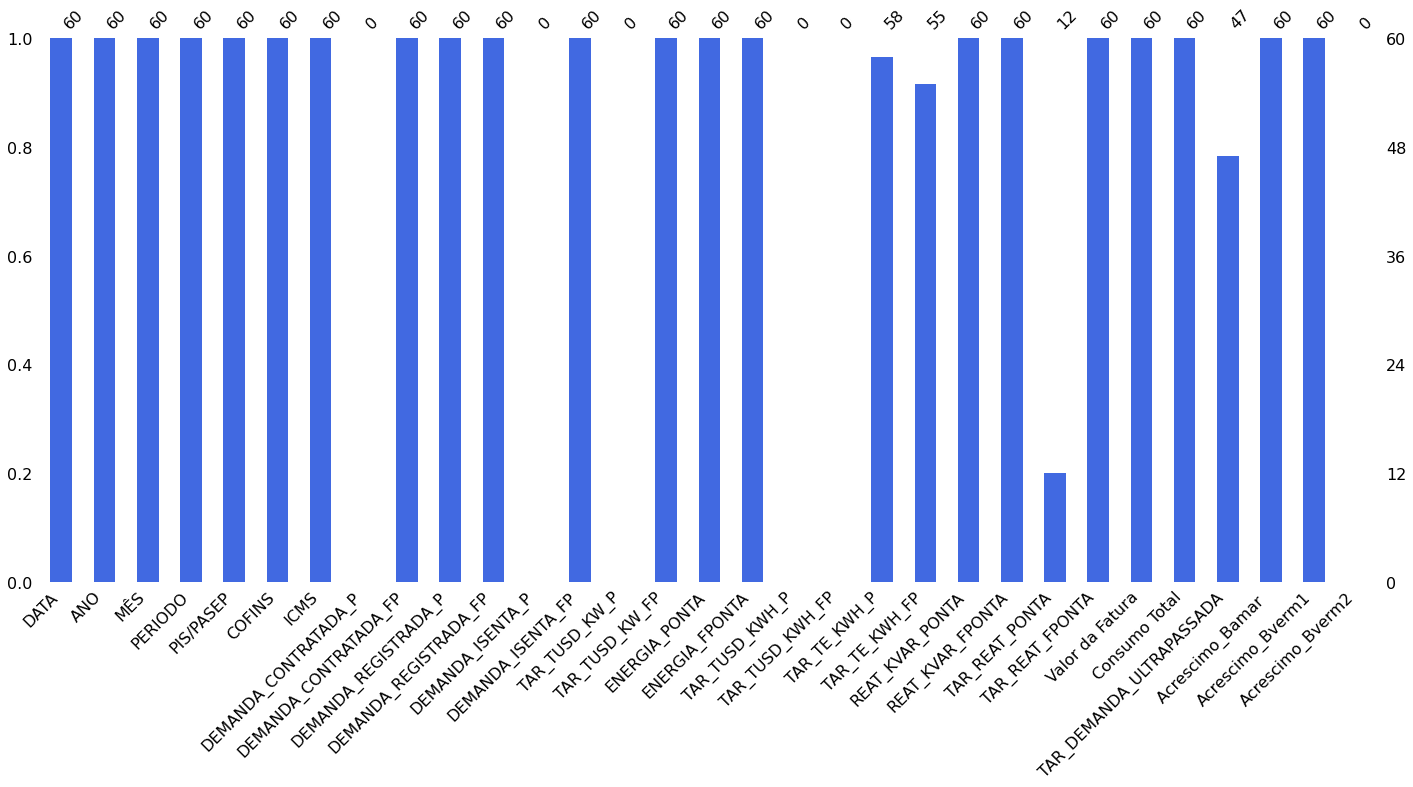

In [ ]:
import missingno as msno
msno.bar(UC1, color="RoyalBlue")

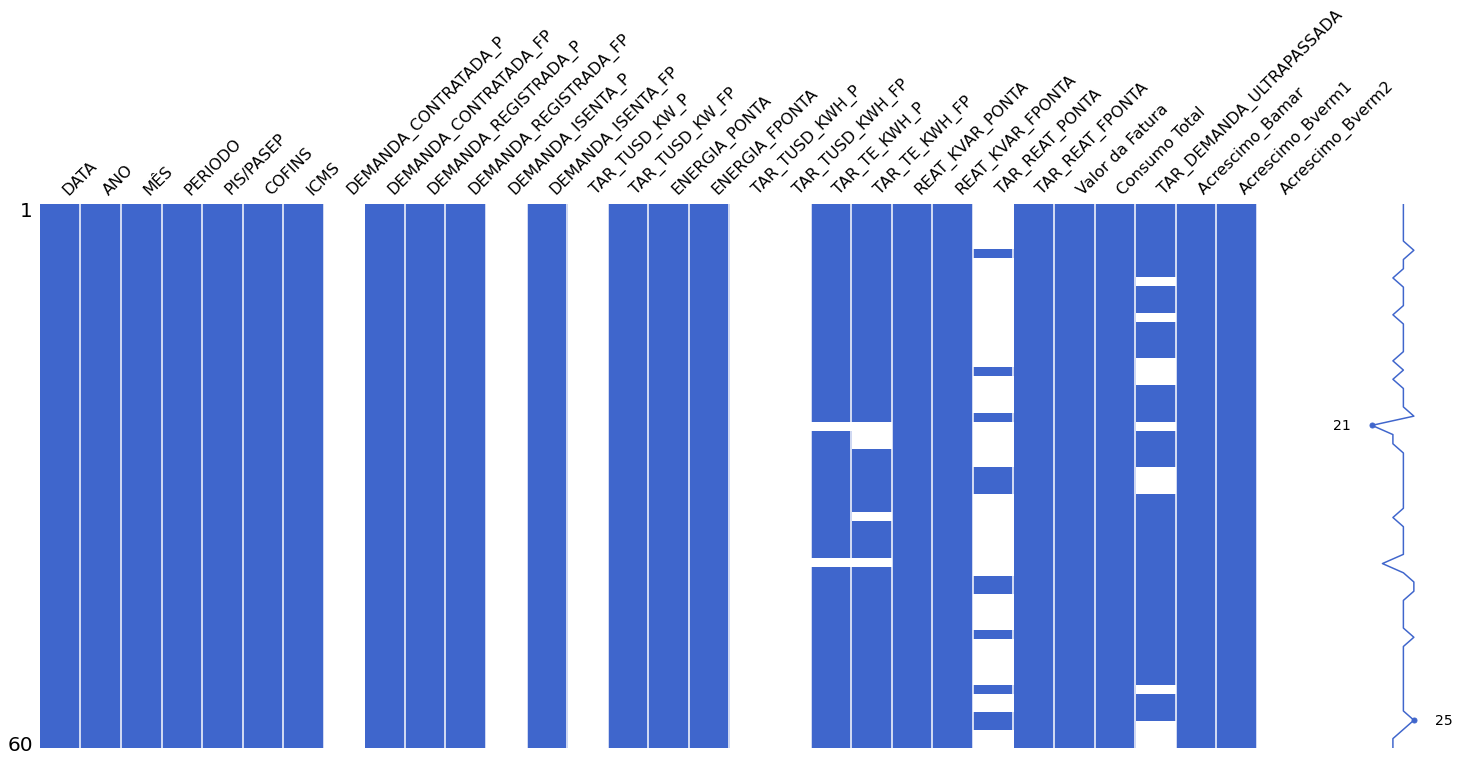

In [ ]:
msno.matrix(UC1, color = (0.25,0.4,0.8))

## Redução do banco de dados
Nessa etapa fazemos a redução do banco de dados original, de forma que apenas as colunas com um número maior do que 50% de dados preenchidos sejam mantidas. Ao executar essa primeira limpa dos dados, as 31 colunas originais passam a ser 24.

In [ ]:
UC1_df = UC1.drop(set(UC1.columns[UC1.isnull().mean() >0.50]), 1)
UC1_df.shape

(60, 24)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

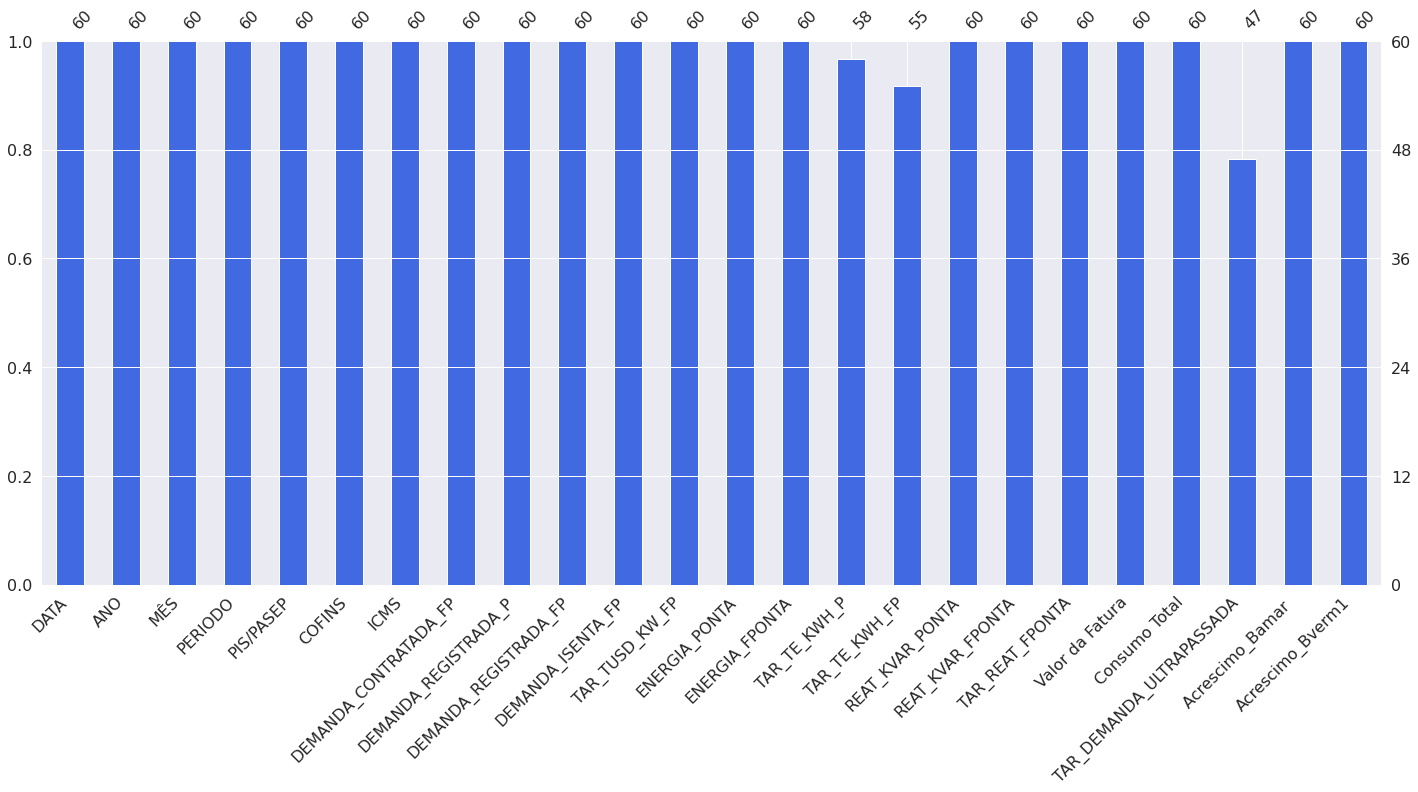

In [ ]:
msno.bar(UC1_df, color="RoyalBlue")

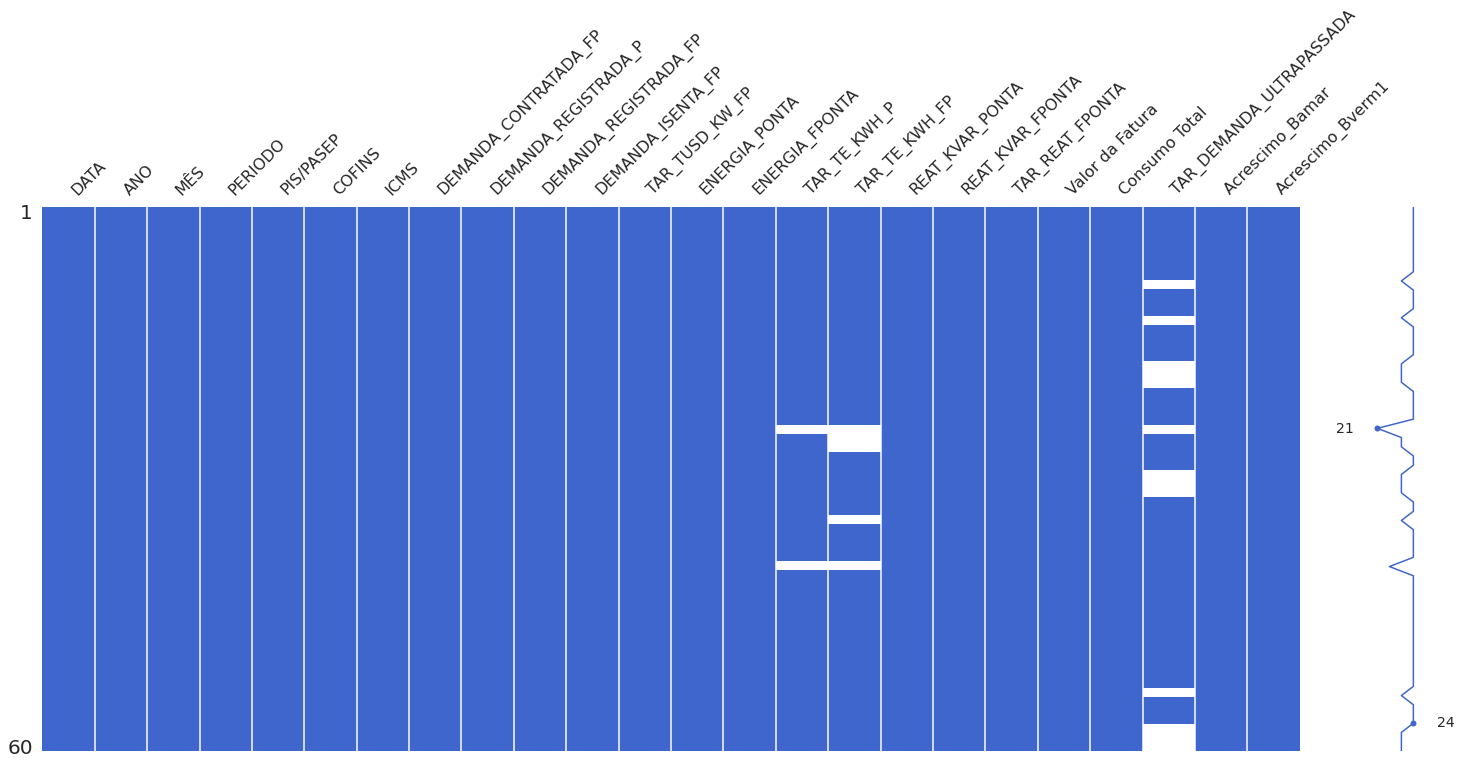

In [ ]:
msno.matrix(UC1_df, color = (0.25,0.4,0.8))

## Plotagem dos dados
Nessa primeria plotagem dos dados, estão mostrados todos os dados da planilha (exceto as colunas retiradas na última ação) com relação ao tempo (data da fatura).

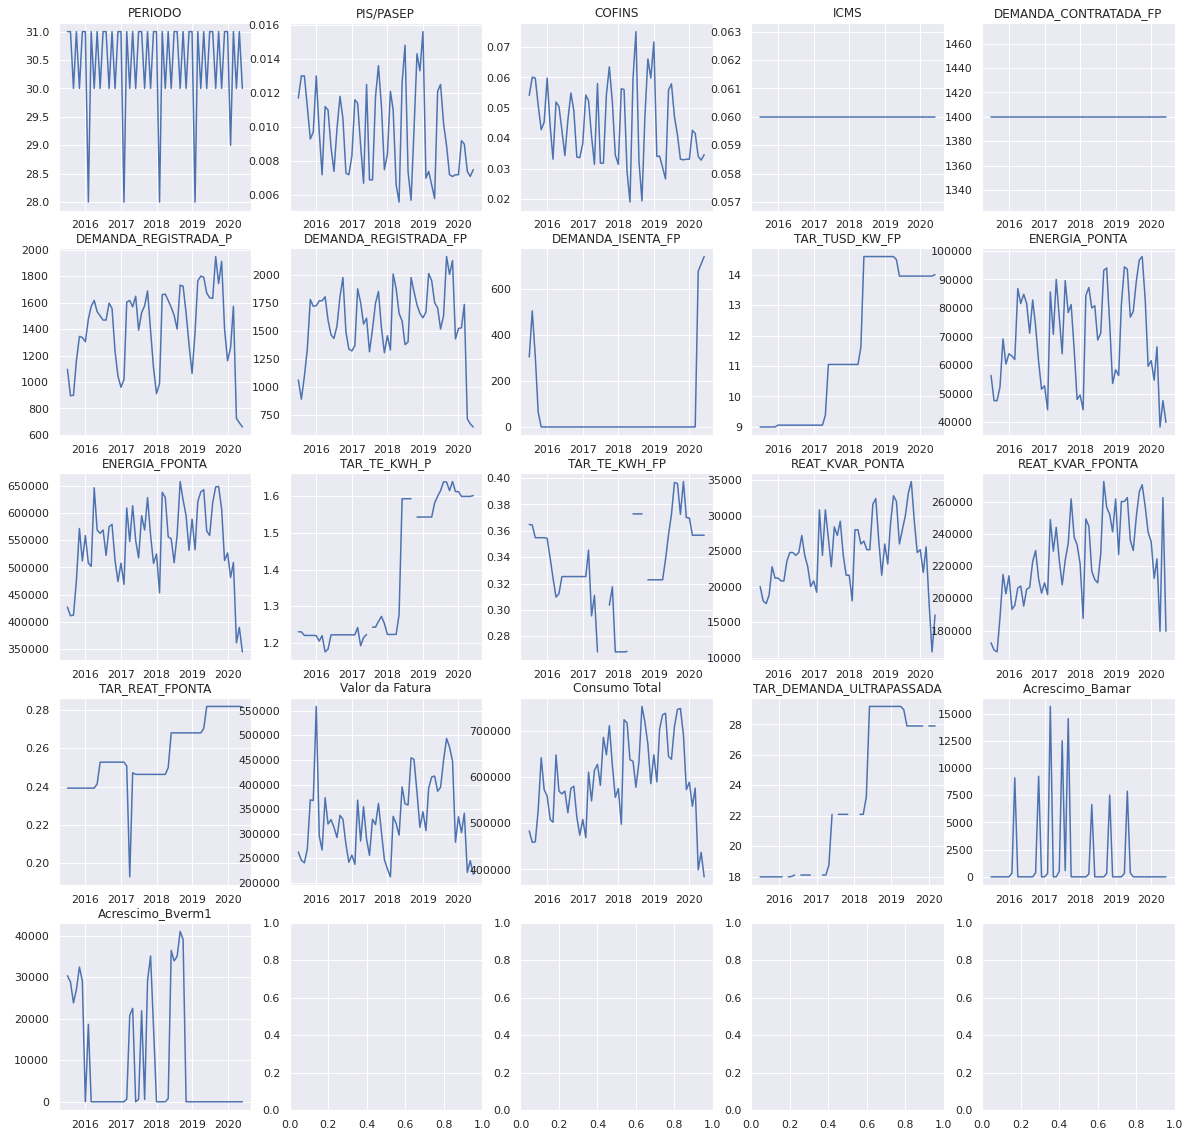

In [ ]:
f, axs = plt.subplots(5, 5,figsize=(20,20))
for i,col in enumerate(UC1_df.columns[3:]):
  plt.subplot(5, 5, i+1)
  plt.title(col)
  plt.plot(UC1_df.DATA, UC1_df[col])

Podemos verificar que a maioria dos dados estão completos, com exceção das colunas de tarifa de energia (ponta e fora da ponta) e tarfifa de demanda ultrapassada.
Observações importantes dessa etapa:
1.   Numa plotagem inicial foram observados que os dados de acréscimo de valor 
da fatura devido a bandeira de energia (amarela ou vermelha) estavam vazios para os meses em que não houve esse acréscimo. Foi feita então a modificação direto na planilha, incluindo os valores como 0 para os casos.
2.   Também na plotagem inicial foram observados quatro possíveis outliers. Dois desses outliers se encontravam nas colunas de energia reativa ponta e fora ponta, e se confirmaram como dados incorretos (foram passados equivocadamente para a planilha), e daí corrigidos. Os outros 2 outliers se mostraram dados reais. São os casos de valor da fatura em Jan/2016, que estava bem acima da média, mas foi um mês em que a UFJF pagou um montante bem elevado em multas de energia; e o outro de tarfia de energia reativa fora da ponta em Abr/2017, que estava abaixo da média dos meses próximos, mas se mostrou como dado real de acordo com a fatura desse mês.


## Imputações

Como todos os casos de dados faltantes se tratavam de tarifas, foi utilizado método de forward fill, visto que é esperado que a tarifa de energia não se altere de um mês para o seguinte. Para o caso da tarifa de demanda ultrapassada, isso aparentemente não foi um problema pois os dados anteriores e posteriores a todos os casos faltantes eram iguais. Para as tarifas de energia (ponta e fora ponta) esse não era sempre o caso, mas após discussão entre a equipe foi decidido manter o método forward fill, com o argumento indicado inicialmente.   

### Exemplo de uma coluna com dados faltantes (tarifa sob demanda ultrapassada)

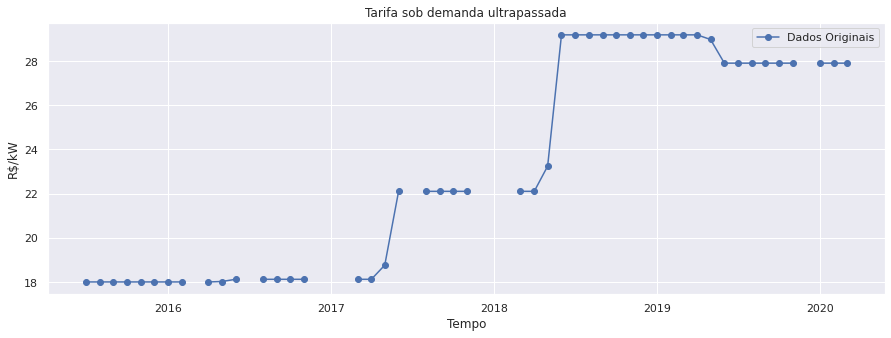

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(UC1_df.DATA, UC1_df.TAR_DEMANDA_ULTRAPASSADA, marker='o', color="b")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("R$/kW")
_ = plt.legend(['Dados Originais'])
_ = plt.title("Tarifa sob demanda ultrapassada")
plt.show()

### Imputação para tarfia de demanda ultrapassada

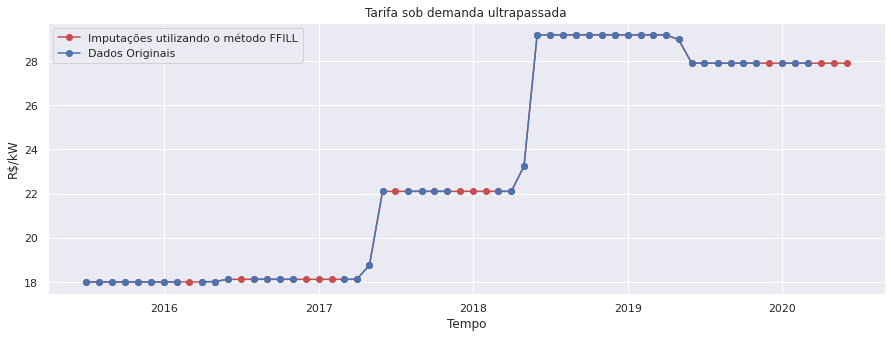

In [ ]:
UC1_ffill = UC1_df.fillna(method='ffill')
sns.set()
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(UC1_ffill.DATA, UC1_ffill.TAR_DEMANDA_ULTRAPASSADA, marker='o', color="r")
_ = plt.plot(UC1_df.DATA, UC1_df.TAR_DEMANDA_ULTRAPASSADA, marker='o', color="b")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("R$/kW")
_ = plt.legend(['Imputações utilizando o método FFILL', 'Dados Originais'])
_ = plt.title("Tarifa sob demanda ultrapassada")
plt.show()

### Imputação para tarfia de energia ponta

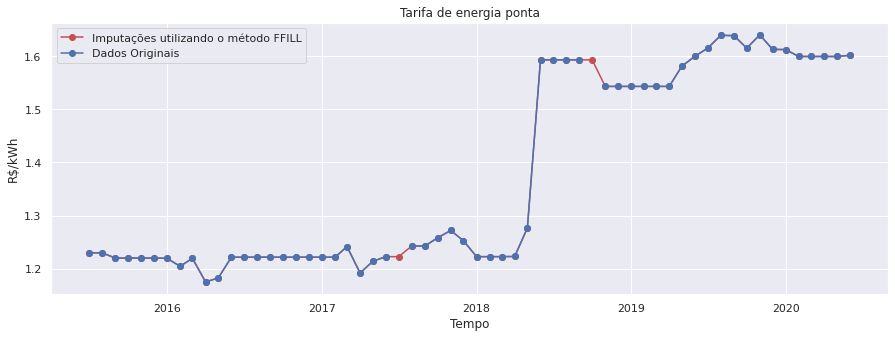

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(UC1_ffill.DATA, UC1_ffill.TAR_TE_KWH_P, marker='o', color="r")
_ = plt.plot(UC1_df.DATA, UC1_df.TAR_TE_KWH_P, marker='o', color="b")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("R$/kWh")
_ = plt.legend(['Imputações utilizando o método FFILL', 'Dados Originais'])
_ = plt.title("Tarifa de energia ponta")
plt.show()

### Imputação para tarfia de energia fora ponta

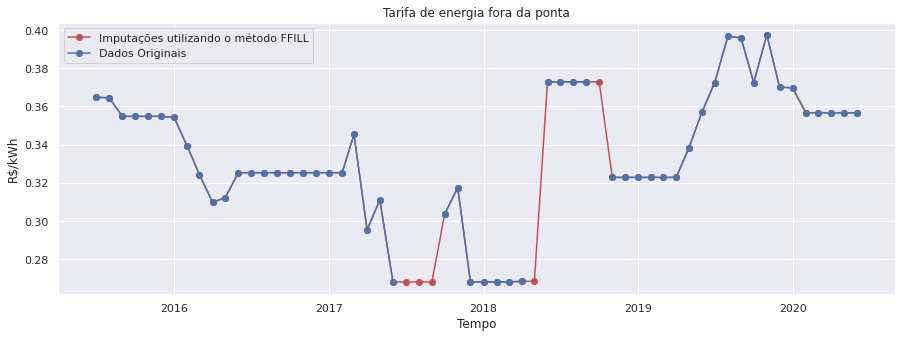

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(UC1_ffill.DATA, UC1_ffill.TAR_TE_KWH_FP, marker='o', color="r")
_ = plt.plot(UC1_df.DATA, UC1_df.TAR_TE_KWH_FP, marker='o', color="b")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("R$/kWh")
_ = plt.legend(['Imputações utilizando o método FFILL', 'Dados Originais'])
_ = plt.title("Tarifa de energia fora da ponta")
plt.show()

## Verificação dos dados completos

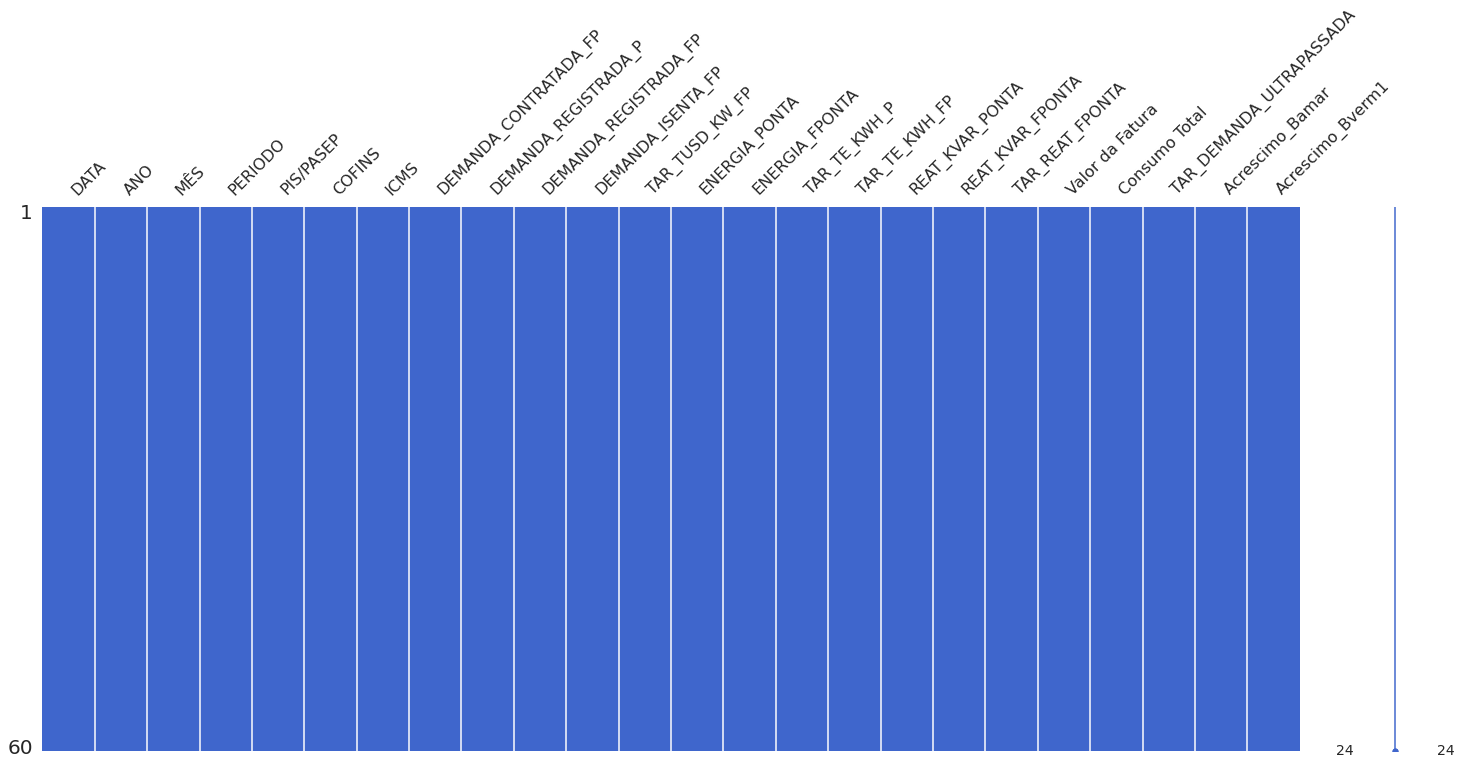

In [ ]:
msno.matrix(UC1_ffill, color = (0.25,0.4,0.8))

# Resumo Banco de Dados

Nessa seção são mostradas algumas informações da base de dados final que foi alcançada com as preparações feitas anteriormente. 

Na primeira tabela são indicados alguns parâmetros estatísticos do banco (valor médio, mediana, erro padrão, etc.), para cada uma das colunas. Na segunda tabela é mostrado um resumo do tipo das variáveis disponíveis.

Na sequência são mostrados os boxplots, que ilustram melhor a situação dos dados de cada coluna, indicando outliers, onde está a mediana e os pontos os 25% maiores e 75% menores dados se encaixam. 

Por fim, a matriz de correlação de todas as variáveis do banco de dados, onde é indicado de uma forma mais visual as variáveis que possuem maior e menor relação entre si.

In [ ]:
UC1_ffill.describe()

,ANO,MÊS,PERIODO,PIS/PASEP,COFINS,ICMS,DEMANDA_CONTRATADA_FP,DEMANDA_REGISTRADA_P,DEMANDA_REGISTRADA_FP,DEMANDA_ISENTA_FP,TAR_TUSD_KW_FP,ENERGIA_PONTA,ENERGIA_FPONTA,TAR_TE_KWH_P,TAR_TE_KWH_FP,REAT_KVAR_PONTA,REAT_KVAR_FPONTA,TAR_REAT_FPONTA,Valor da Fatura,Consumo Total,TAR_DEMANDA_ULTRAPASSADA,Acrescimo_Bamar,Acrescimo_Bverm1
count,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2017.500000,6.500000,30.433333,0.009613,0.044283,6.000000e-02,1400.0,1409.400000,1576.866667,55.066667,11.631428,70026.666667,545126.666667,1.377471,0.332072,24680.000000,224446.666667,0.257334,331247.522833,595020.000000,23.251500,1440.207667,8778.872833
std,1.512658,3.481184,0.830900,0.002589,0.012825,4.898216e-17,0.0,309.222601,331.049152,173.170423,2.367453,16280.568293,73822.856840,0.184060,0.037059,4739.334145,27234.583365,0.017763,75235.257025,91216.306155,4.743946,3728.976640,13944.524445
min,2015.000000,1.000000,28.000000,0.005600,0.019000,6.000000e-02,1400.0,660.000000,640.000000,0.000000,9.000000,38400.000000,344000.000000,1.174980,0.268110,10800.000000,166800.000000,0.192898,212391.290000,384000.000000,18.000000,0.000000,0.000000
25%,2016.000000,3.750000,30.000000,0.007200,0.033100,6.000000e-02,1400.0,1214.000000,1421.000000,0.000000,9.060000,56400.000000,508600.000000,1.221630,0.316148,21500.000000,206700.000000,0.246350,275932.067500,534300.000000,18.120000,0.000000,0.000000
50%,2017.500000,6.500000,31.000000,0.009250,0.042700,6.000000e-02,1400.0,1502.000000,1614.000000,0.000000,11.050000,71000.000000,557800.000000,1.242640,0.325280,24800.000000,224000.000000,0.252730,324412.880000,583400.000000,22.100000,0.000000,0.000000
75%,2019.000000,9.250000,31.000000,0.011725,0.054600,6.000000e-02,1400.0,1620.000000,1771.000000,0.000000,13.950000,82800.000000,598700.000000,1.593330,0.356785,28000.000000,245800.000000,0.268010,369974.650000,647600.000000,27.900000,308.600000,21119.302500
max,2020.000000,12.000000,31.000000,0.015600,0.075100,6.000000e-02,1400.0,1948.000000,2164.000000,740.000000,14.590000,98000.000000,658800.000000,1.640438,0.397408,34800.000000,272400.000000,0.281810,558614.370000,752000.000000,29.180000,15658.820000,41097.360000


In [ ]:
UC1_ffill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATA                      60 non-null     datetime64[ns]
 1   ANO                       60 non-null     int64         
 2   MÊS                       60 non-null     int64         
 3   PERIODO                   60 non-null     int64         
 4   PIS/PASEP                 60 non-null     float64       
 5   COFINS                    60 non-null     float64       
 6   ICMS                      60 non-null     float64       
 7   DEMANDA_CONTRATADA_FP     60 non-null     int64         
 8   DEMANDA_REGISTRADA_P      60 non-null     int64         
 9   DEMANDA_REGISTRADA_FP     60 non-null     int64         
 10  DEMANDA_ISENTA_FP         60 non-null     int64         
 11  TAR_TUSD_KW_FP            60 non-null     float64       
 12  ENERGIA_PONTA           

## Boxplot

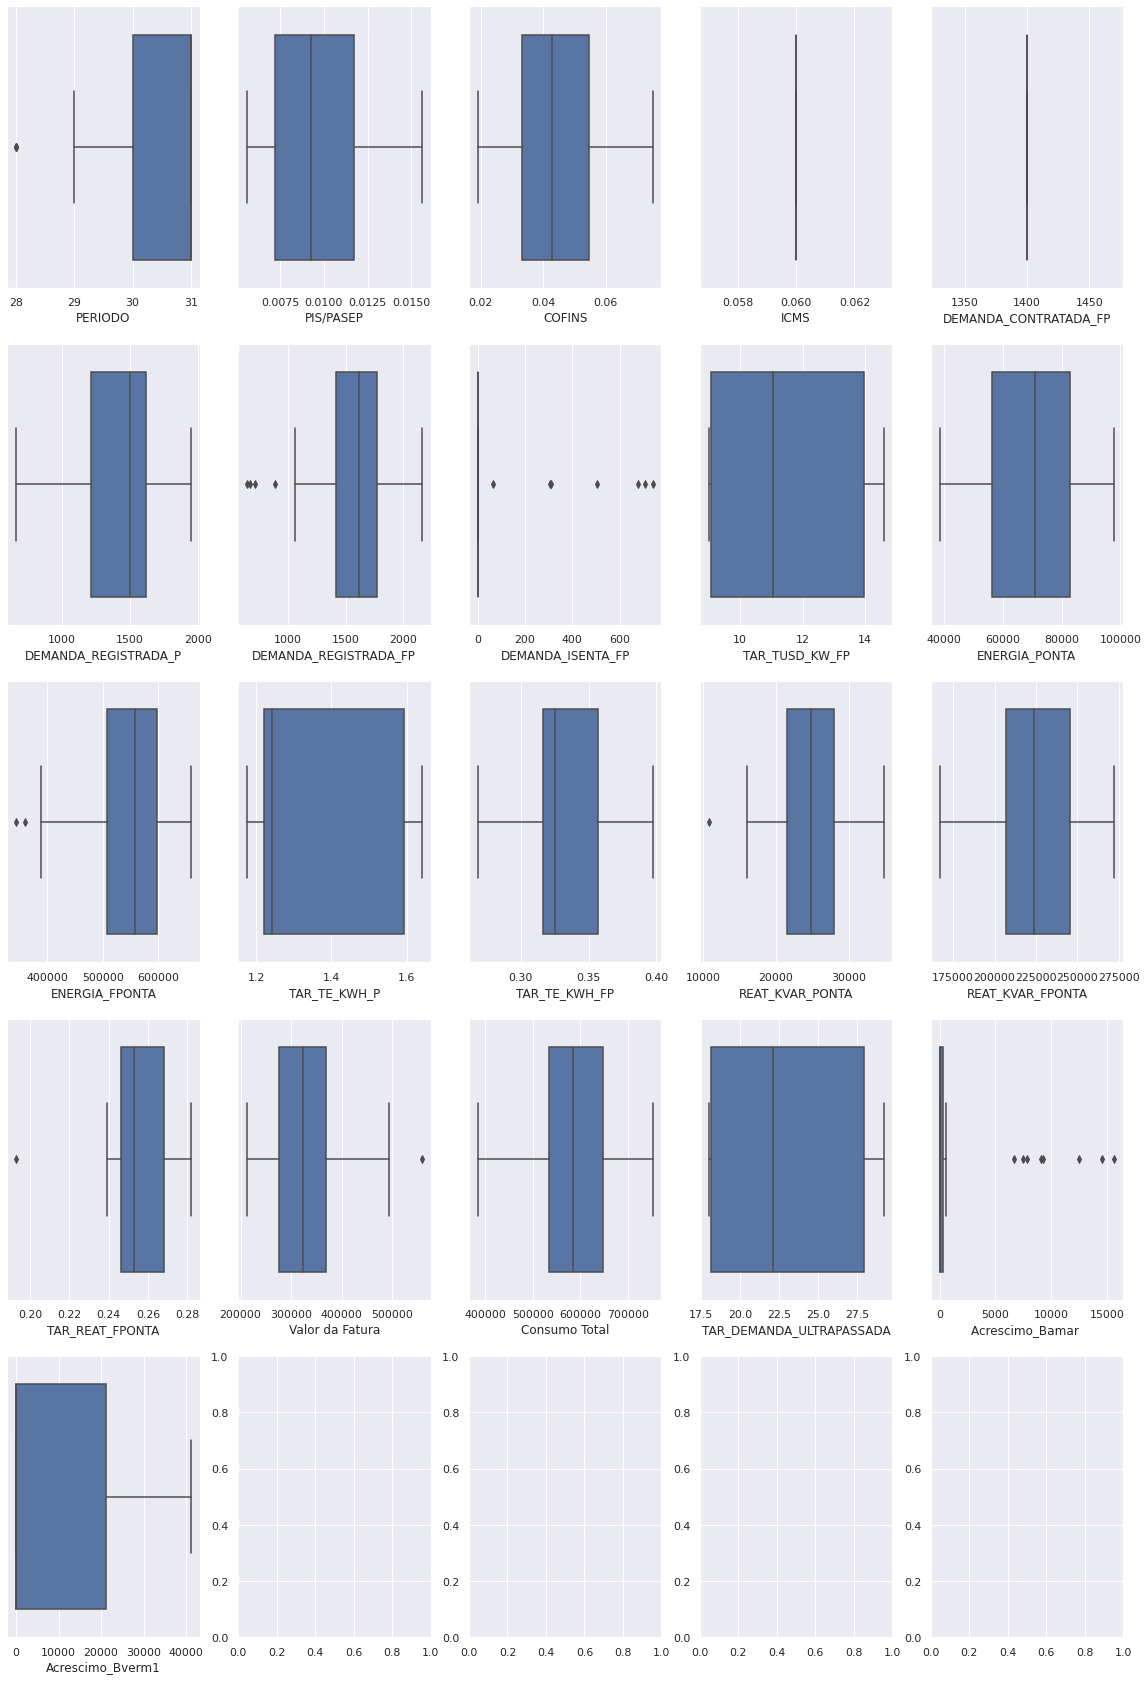

In [ ]:
f, axs = plt.subplots(5, 5,figsize=(20,30))
for i,col in enumerate(UC1_ffill.columns[3:]):
  plt.subplot(5, 5, i+1)
  sns.boxplot(x=UC1_ffill[col])

## Gráficos finais (dados x tempo)

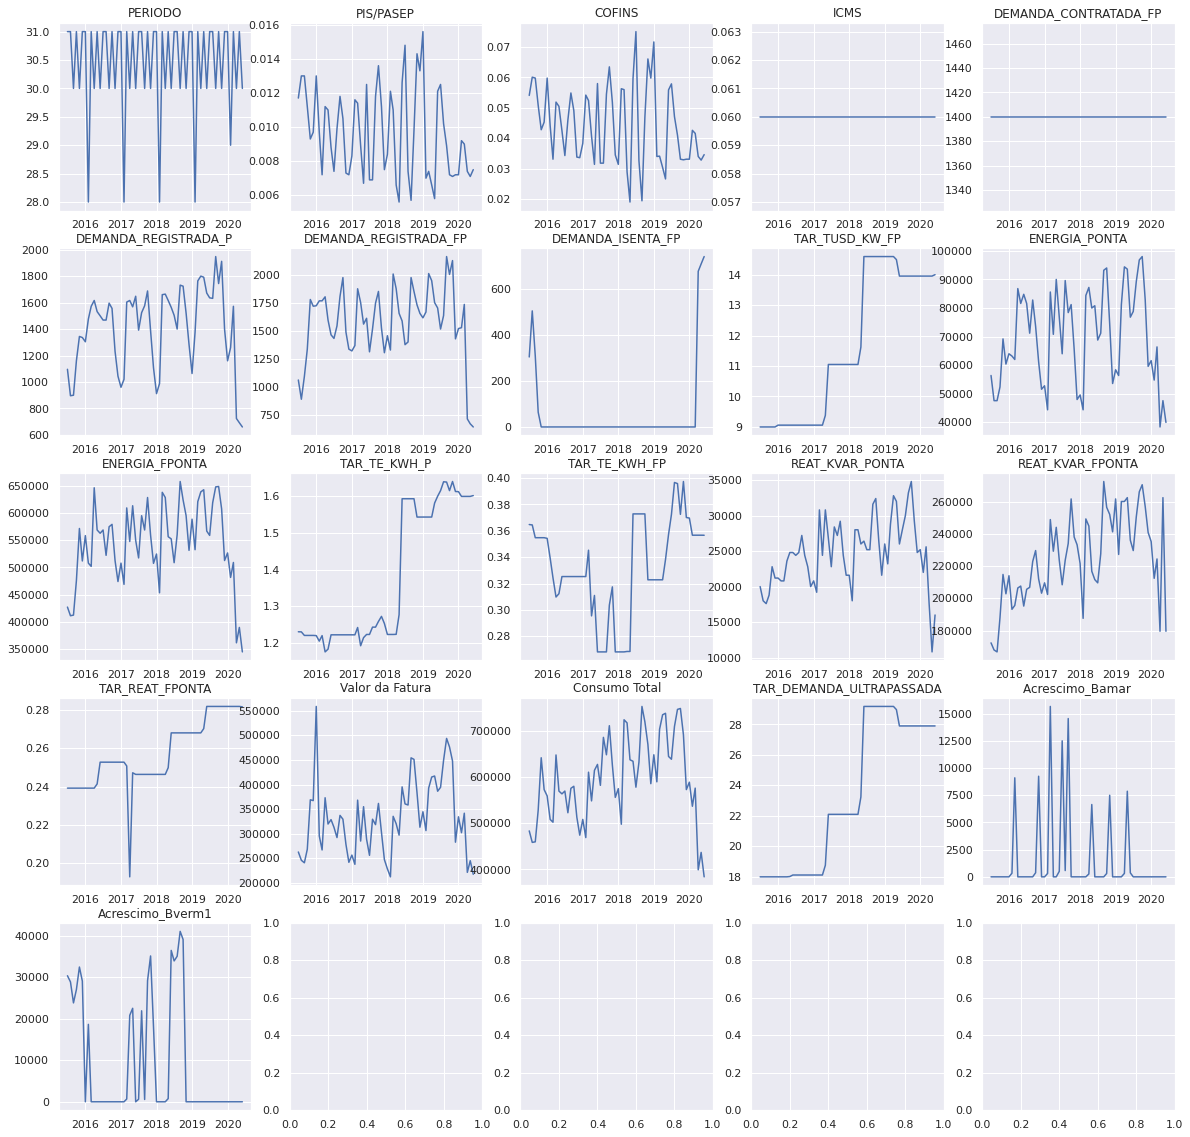

In [ ]:
f, axs = plt.subplots(5, 5,figsize=(20,20))
for i,col in enumerate(UC1_ffill.columns[3:]):
  plt.subplot(5, 5, i+1)
  plt.title(col)
  plt.plot(UC1_ffill.DATA, UC1_ffill[col])

## Correlação entre dados

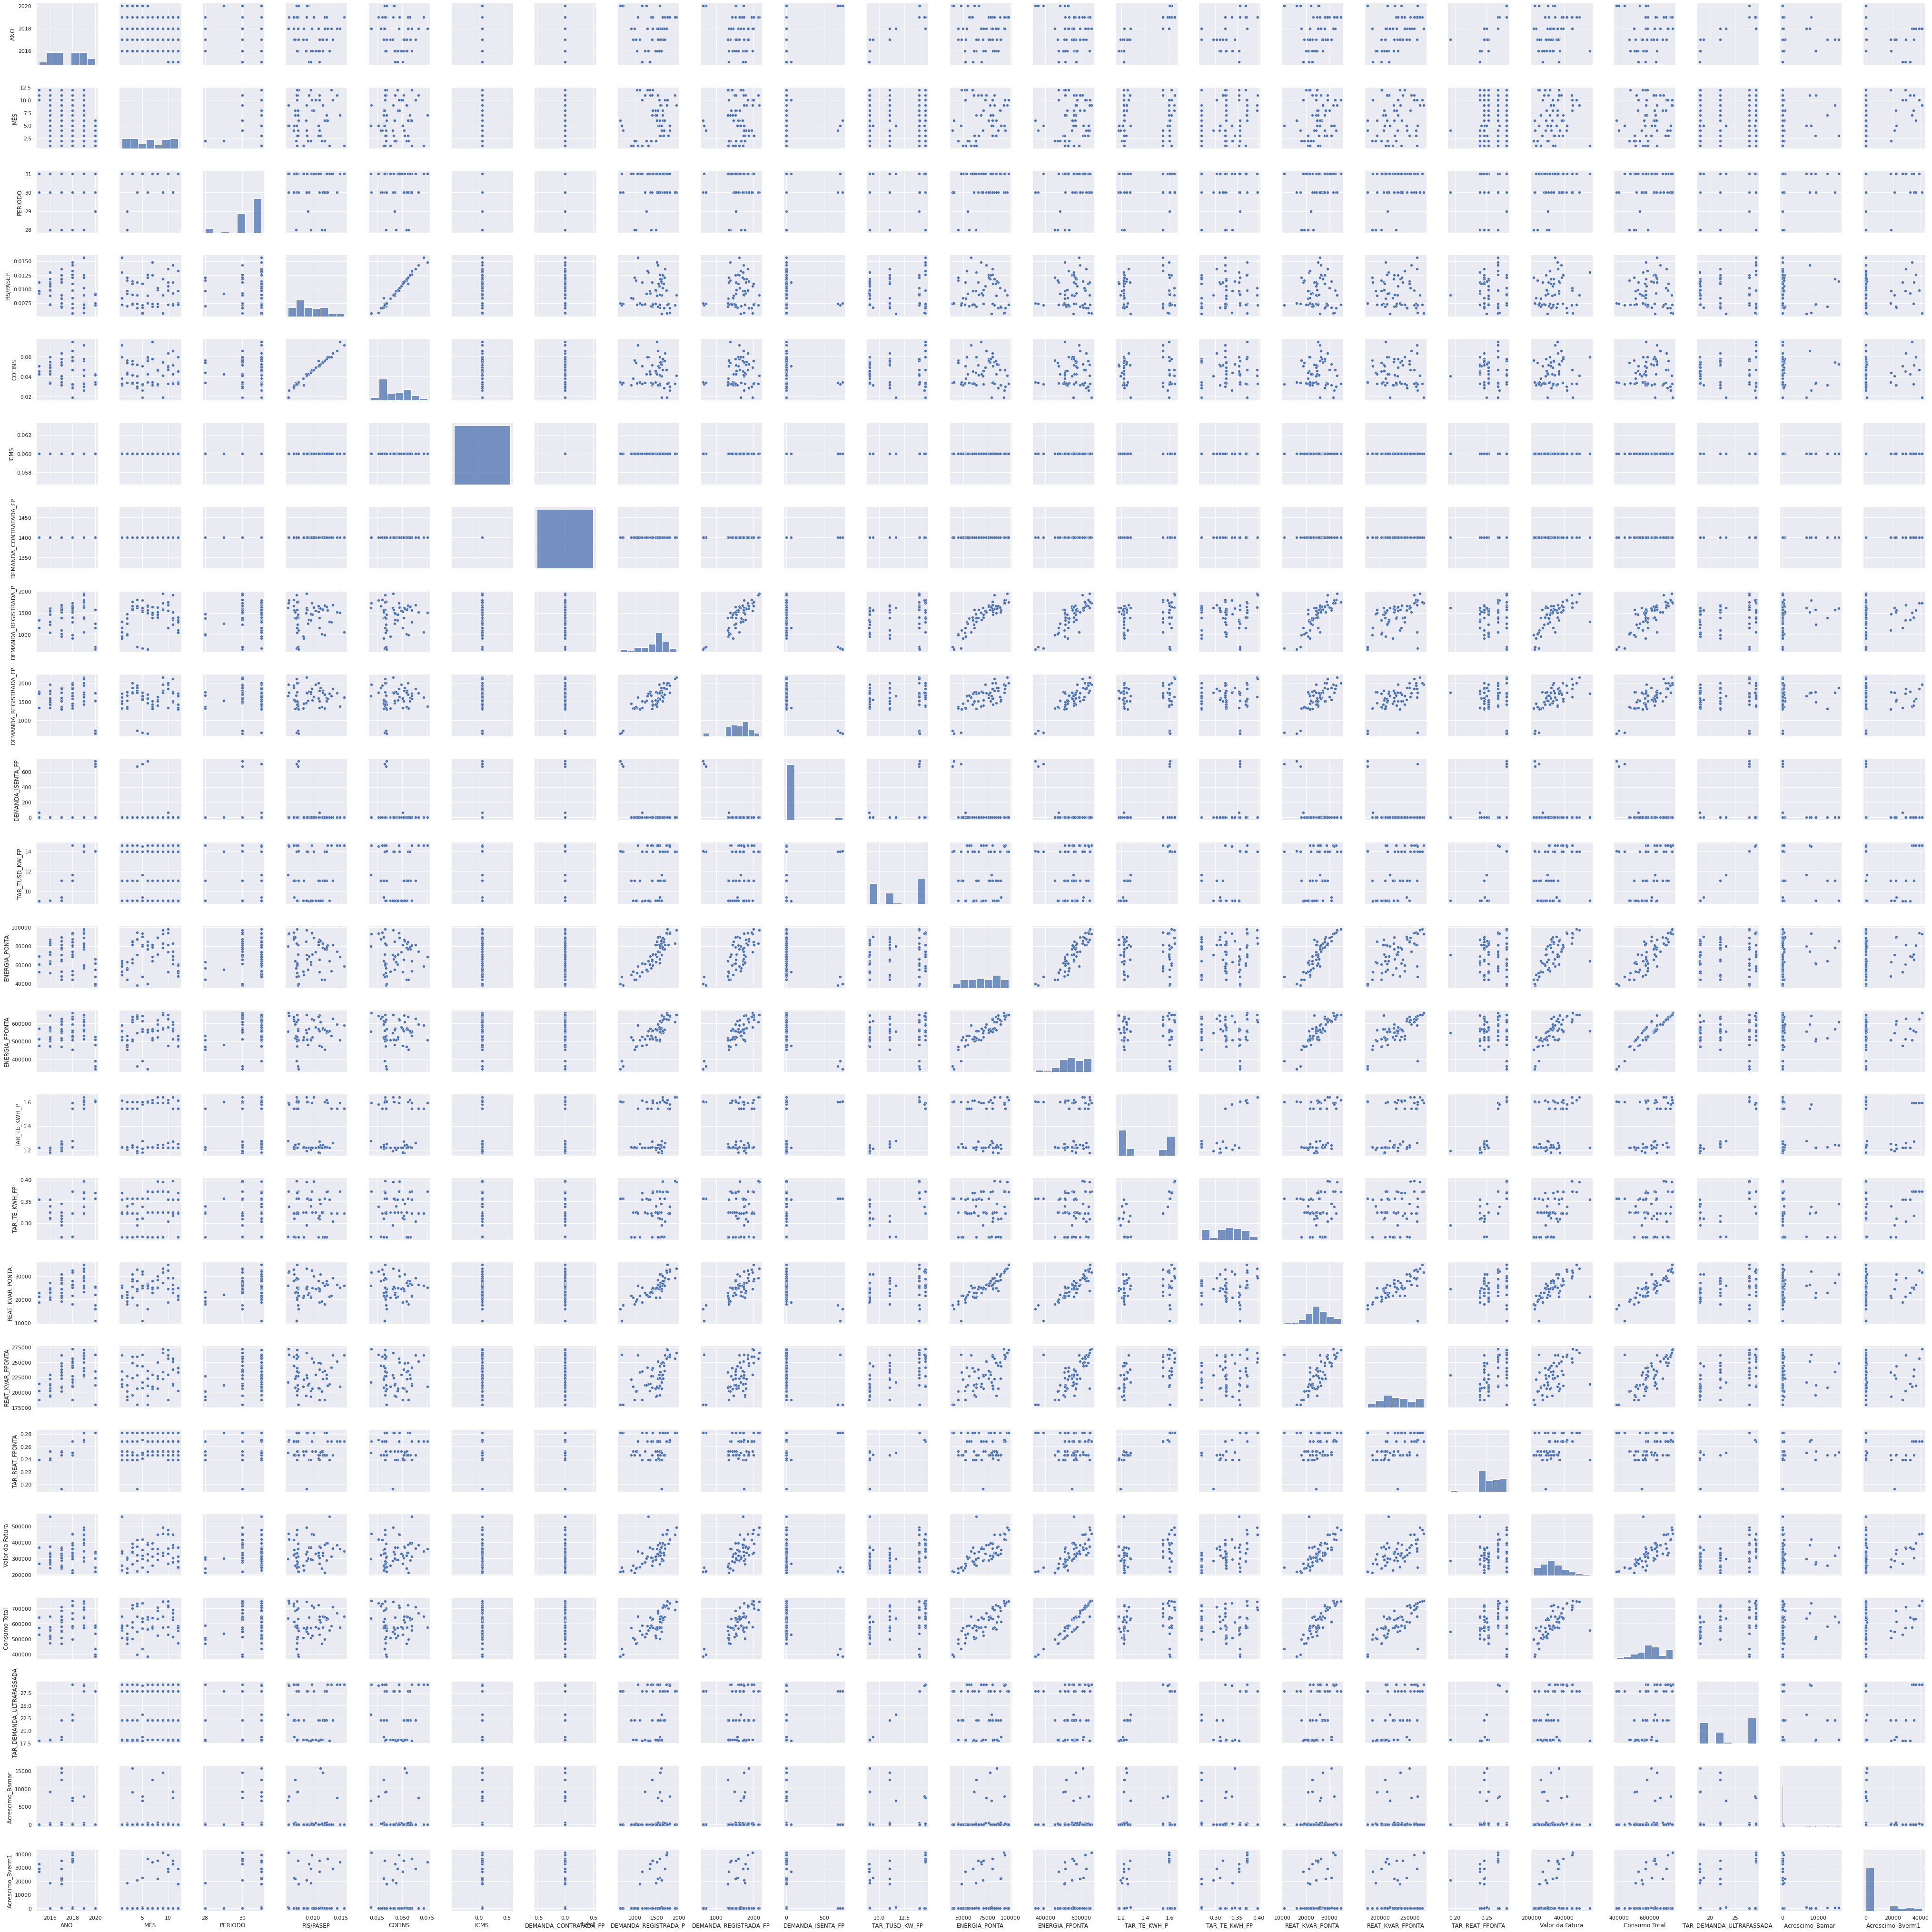

In [ ]:
sns.pairplot(UC1_ffill[3:], palette='bwr')

# Teste das Previsões

Os treinos foram feitos considerando os meses de 2015 a 2018 e os testes considerando o ano de 2019. Foi descartado o ano de 2020 de forma que as previsões não sejam deturpadas pela pandemia. As previsões foram feitas utilizando a função ARIMA, demonstrada em sala de aula.

Pelos resultados das previsões, foi possível evidenciar uma boa taxa de assertividade com relação ao periíodo de teste, com baixos valores de erro médio (RMSE), validando a função utilizada.

Diferente do caso exposto na aula, os dados da UFJF já estavam com poucos dados faltantes, e além disso os casos faltates não eram os dados cruciais para análise, como consumo, demanda e valor de fatura. Por conta disso, não foi necessário comparar os diferentes tipos de imputações que poderiam ser utilizados em prol da previsão mais assertiva.

## Divisão treino/teste (exemplo)

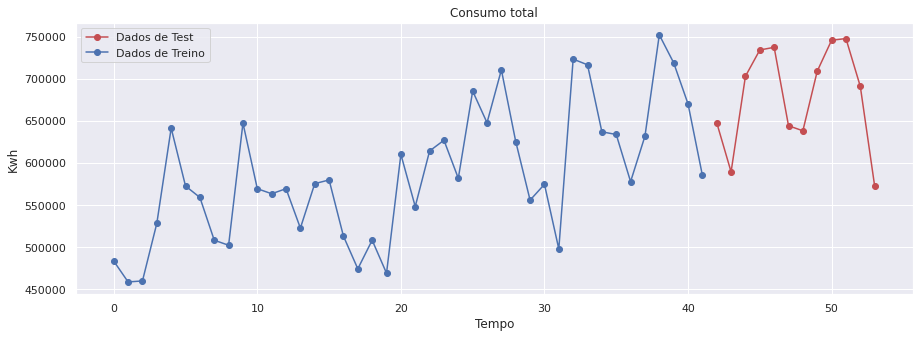

In [ ]:
df_train = UC1_ffill["Consumo Total"].iloc[:42]
df_test = UC1_ffill["Consumo Total"].iloc[42:54]
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(df_test, marker='o', color="r")
_ = plt.plot(df_train, marker='o', color="b")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("Kwh")
_ = plt.legend([ 'Dados de Test', 'Dados de Treino'])
_ = plt.title("Consumo total")
plt.show()

In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_train)

(0.012618457883869916, False)

In [ ]:
from pmdarima.arima import auto_arima

## Teste de previsão (Consumo)

In [ ]:
arima_model = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

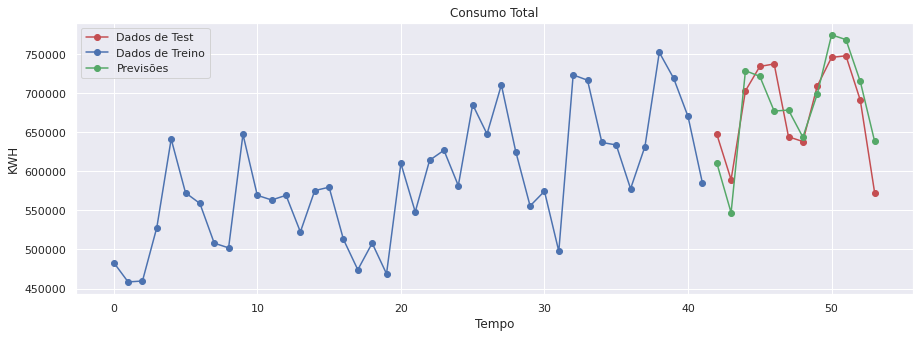

In [ ]:
previsoes = pd.DataFrame(arima_model.predict(n_periods = 12), index =df_test.index)
previsoes.columns = ['previsoes']
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(df_test, marker='o', color="r")
_ = plt.plot(df_train, marker='o', color="b")
_ = plt.plot(previsoes, marker='o', color="g")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("KWH")
_ = plt.legend([ 'Dados de Test', 'Dados de Treino', 'Previsões'])
_ = plt.title("Consumo Total")
plt.show()

### Avaliação erro médio (RMSE)

In [ ]:
def RMSE(yh, y):
  er = yh - y
  RMSE = sum(er*er/len(er))**0.5
  return RMSE
np.mean(RMSE(df_test.values, previsoes.values))

83795.61881479835

## Teste de previsão (Valor da fatura)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=752.979, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=743.945, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=741.554, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=749.000, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=743.552, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=743.551, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=743.032, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=745.529, Time=0.56 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=742.118, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=743.179, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=739.129, Time=0.13 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=756.725, Time=0.03 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=740.899, Time=0.23 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=740.859, Time=0.28 sec
 ARIMA(0,1,2)(1,1,0)[12]         

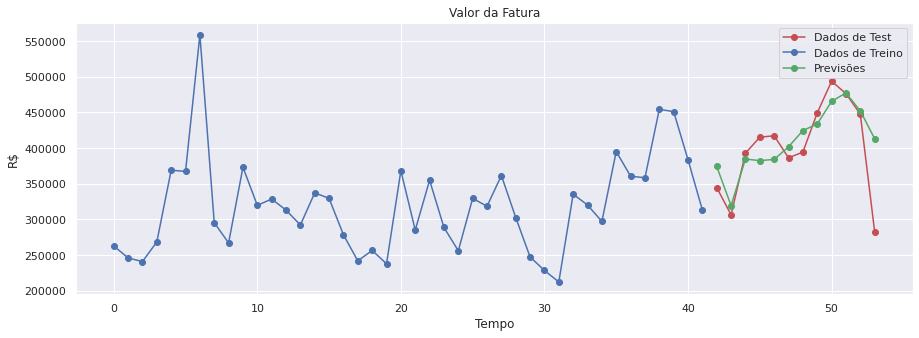

In [ ]:
df_train = UC1_ffill["Valor da Fatura"].iloc[:42]
df_test = UC1_ffill["Valor da Fatura"].iloc[42:54]
arima_model = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)
previsoes = pd.DataFrame(arima_model.predict(n_periods = 12), index =df_test.index)
previsoes.columns = ['previsoes']
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(df_test, marker='o', color="r")
_ = plt.plot(df_train, marker='o', color="b")
_ = plt.plot(previsoes, marker='o', color="g")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("R$")
_ = plt.legend([ 'Dados de Test', 'Dados de Treino', 'Previsões'])
_ = plt.title("Valor da Fatura")
plt.show()

### Avaliação erro médio (RMSE)

In [ ]:
def RMSE(yh, y):
  er = yh - y
  RMSE = sum(er*er/len(er))**0.5
  return RMSE
np.mean(RMSE(df_test.values, previsoes.values))

69781.46512051935

## Teste de previsão (Demanda fora ponta)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=404.009, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=407.185, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=405.892, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=405.742, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=405.300, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=405.332, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=406.009, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.852 seconds


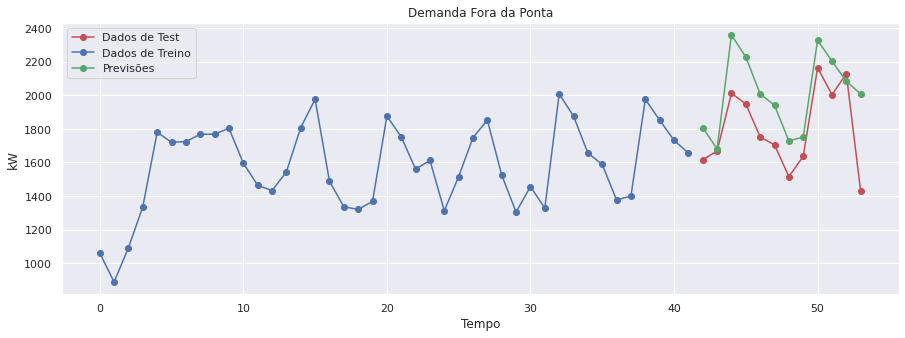

In [ ]:
df_train = UC1_ffill["DEMANDA_REGISTRADA_FP"].iloc[:42]
df_test = UC1_ffill["DEMANDA_REGISTRADA_FP"].iloc[42:54]
arima_model = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)
previsoes = pd.DataFrame(arima_model.predict(n_periods = 12), index =df_test.index)
previsoes.columns = ['previsoes']
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(df_test, marker='o', color="r")
_ = plt.plot(df_train, marker='o', color="b")
_ = plt.plot(previsoes, marker='o', color="g")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("kW")
_ = plt.legend([ 'Dados de Test', 'Dados de Treino', 'Previsões'])
_ = plt.title("Demanda Fora da Ponta")
plt.show()

### Avaliação erro médio (RMSE)

In [ ]:
def RMSE(yh, y):
  er = yh - y
  RMSE = sum(er*er/len(er))**0.5
  return RMSE
np.mean(RMSE(df_test.values, previsoes.values))

367.7971586834869

## Teste de previsão (Demanda ponta)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=388.593, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.947, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=391.801, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=389.960, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=389.804, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=391.708, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=390.450, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=390.473, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=390.556, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.889 seconds


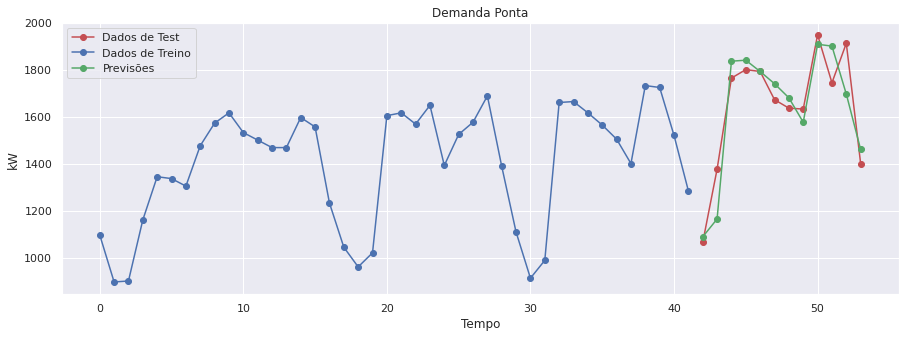

In [ ]:
df_train = UC1_ffill["DEMANDA_REGISTRADA_P"].iloc[:42]
df_test = UC1_ffill["DEMANDA_REGISTRADA_P"].iloc[42:54]
arima_model = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)
previsoes = pd.DataFrame(arima_model.predict(n_periods = 12), index =df_test.index)
previsoes.columns = ['previsoes']
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(df_test, marker='o', color="r")
_ = plt.plot(df_train, marker='o', color="b")
_ = plt.plot(previsoes, marker='o', color="g")
_ = plt.xlabel("Tempo")
_ = plt.ylabel("kW")
_ = plt.legend([ 'Dados de Test', 'Dados de Treino', 'Previsões'])
_ = plt.title("Demanda Ponta")
plt.show()

### Avaliação erro médio (RMSE)

In [ ]:
def RMSE(yh, y):
  er = yh - y
  RMSE = sum(er*er/len(er))**0.5
  return RMSE
np.mean(RMSE(df_test.values, previsoes.values))

342.614751929384

# Previsões futuras

Com o teste de previsões pelo ARIMA validado, é possível fazer as previsões para os dados a serem utilizados no estudo de contrato no mercado livre. 

A matriz "previsões", que é o output da próxima linha de código, indica os valores de previsão dos meses de jan/2022 a dez/2025, considerando como treino todos os valores da planilha até a data de dez/2019. 

Foram descartados da análise os anos de 2020 e 2021 por conta das incertezas que a pandemia poderia gerar no resultado, e considerada uma hipótese de que 2022 seria um ano já com aulas e atividades normais na universidade, e o ano escolhido para estudo da viabiabilidade de entrada no mercado livre. 

In [ ]:
df_train = UC1_ffill["Consumo Total"].iloc[:54]
df_test = UC1_ffill["Consumo Total"].iloc[1:49]
arima_model_con = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                             max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

df_train = UC1_ffill["Valor da Fatura"].iloc[:54]
df_test = UC1_ffill["Valor da Fatura"].iloc[1:49]
arima_model_fat = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                             max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

df_train = UC1_ffill["DEMANDA_REGISTRADA_P"].iloc[:54]
df_test = UC1_ffill["DEMANDA_REGISTRADA_P"].iloc[1:49]
arima_model_dp = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                            max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

df_train = UC1_ffill["DEMANDA_REGISTRADA_FP"].iloc[:54]
df_test = UC1_ffill["DEMANDA_REGISTRADA_FP"].iloc[1:49]
arima_model_dfp = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                             max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

df_train = UC1_ffill["TAR_TUSD_KW_FP"].iloc[:54]
df_test = UC1_ffill["TAR_TUSD_KW_FP"].iloc[1:49]
arima_model_tusd = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                              max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

df_train = UC1_ffill["TAR_TE_KWH_P"].iloc[:54]
df_test = UC1_ffill["TAR_TE_KWH_P"].iloc[1:49]
arima_model_tep = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                              max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)

df_train = UC1_ffill["TAR_TE_KWH_FP"].iloc[:54]
df_test = UC1_ffill["TAR_TE_KWH_FP"].iloc[1:49]
arima_model_tefp = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, 
                              max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)


In [ ]:

previsoes = {'Consumo': arima_model_con.predict(n_periods = 48), 'Valor da fatura': arima_model_fat.predict(n_periods = 48), 
             'Demanda ponta': arima_model_dp.predict(n_periods = 48), 'Demanda fora ponta': arima_model_dfp.predict(n_periods = 48),
             'TUSD': arima_model_tusd.predict(n_periods = 48),   'TE ponta': arima_model_tep.predict(n_periods = 48),
             'TE fora ponta': arima_model_tefp.predict(n_periods = 48)}
             
previsoes_mat = pd.DataFrame(data=previsoes)
previsoes_mat

,Consumo,Valor da fatura,Demanda ponta,Demanda fora ponta,TUSD,TE ponta,TE fora ponta
0,631137.881634,338667.360111,1246.307842,1610.226730,13.950000,1.611406,0.369883
1,571581.780732,317241.397883,1542.377661,1567.231430,13.950000,1.605141,0.363467
2,707643.596129,393481.370900,1934.204820,2004.006221,13.950000,1.630241,0.372715
3,724830.686694,397452.806074,1969.285361,1918.926149,13.950000,1.564768,0.327590
4,711016.278887,399360.461026,1961.506257,1718.197092,14.085366,1.575800,0.336211
5,654960.422311,403371.431127,1841.453188,1669.534637,14.778403,1.608559,0.311772
6,641195.277660,415938.105571,1805.465938,1478.669110,14.778403,1.602306,0.307247
7,704798.529269,440609.640749,1801.462875,1573.419367,14.778403,1.608692,0.297136
8,754354.189176,479375.437157,2117.463611,2050.576012,14.778403,1.606932,0.294793
9,754682.414501,481741.189552,1913.463434,1965.140497,14.778403,1.633074,0.331352
